# Baseline Model - Private Use Only

This notebook contains the code that we will use to double check the data, the model, the outputs, the functions, etc. all work properly. To do this we will use a simple baseline CNN and test over a subset of COCO. **Everything in this notebook is used only for personal use and private testing only!**

## Libraries import

In [58]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from utils.dataset import CocoDataset
from utils.plots import plot_l, plot_a, plot_b, plot_rgb, reconstruct_lab, plot_predicted_image, plot_ab
from utils.models import BaselineCNN, save_model, load_model


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Import

In [3]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(), # tensorization brings image in range [0,1] and space CxHxW
])

In [4]:
path_sandro = "coco/images/train2014"
path_diego = "C:/Users/diego/coco/images/train2014/train2014"
dataset = CocoDataset(root=path_sandro, transform=transform)

Found 82783 images.


In [5]:
len(dataset)

82783

In [9]:
image, l_channel, a_channel, b_channel, ab_channels = dataset[0]

In [10]:
type(image), type(l_channel), type(a_channel), type(b_channel), type(ab_channels)

(torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor)

In [11]:
image.shape, l_channel.shape, a_channel.shape, b_channel.shape, ab_channels.shape

(torch.Size([3, 64, 64]),
 torch.Size([1, 64, 64]),
 torch.Size([64, 64]),
 torch.Size([64, 64]),
 torch.Size([2, 64, 64]))

Let's test the plotting functions

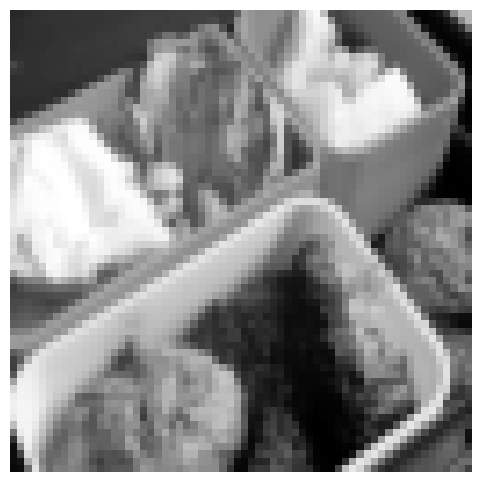

In [12]:
plot_l(l_channel)

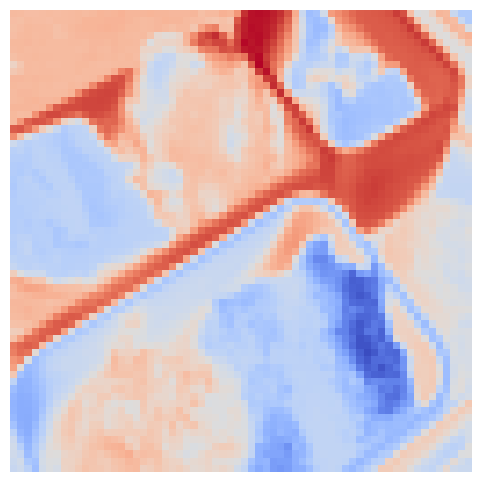

In [13]:
plot_a(a_channel)

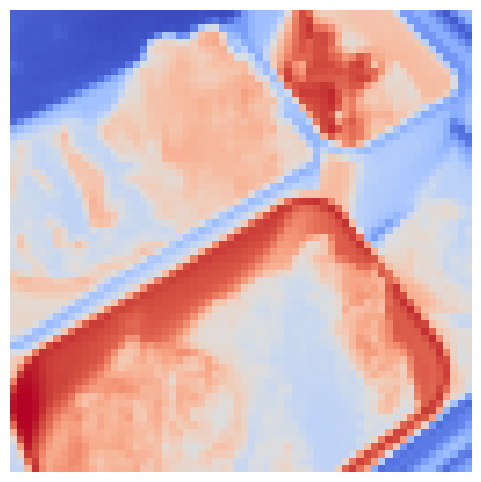

In [14]:
plot_b(b_channel)

c:\Users\diego\image-colorization\utils\plots.py:122: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 627 negative Z values that have been clipped to zero
  rgb_image = lab2rgb(lab_image_np)


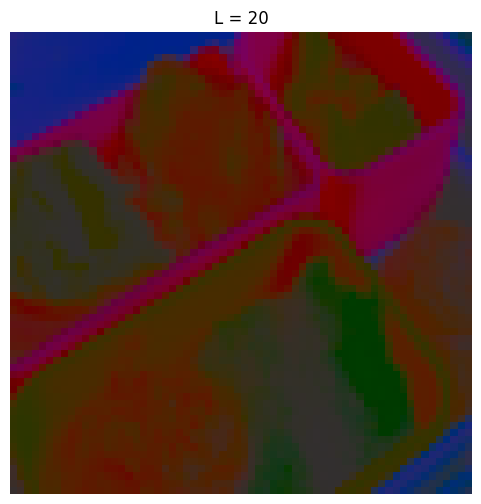

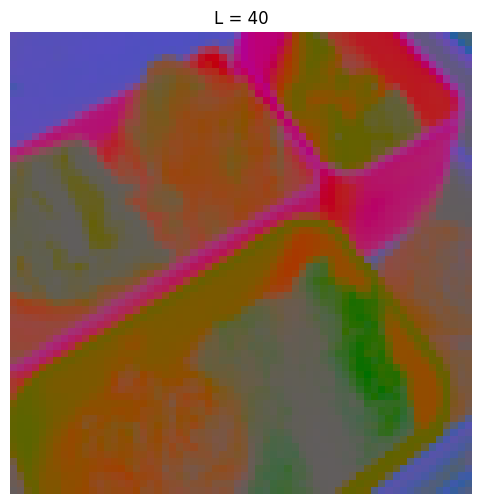

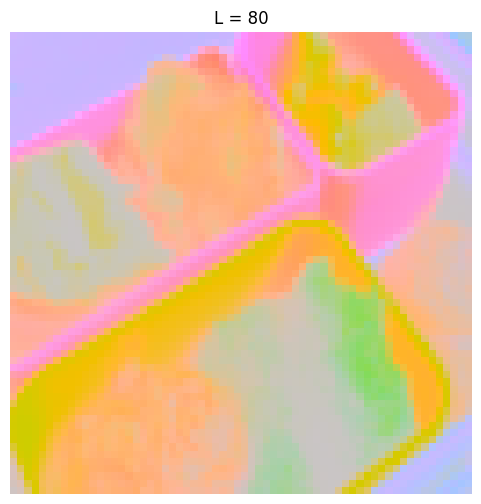

In [17]:
plot_ab(ab_channels)

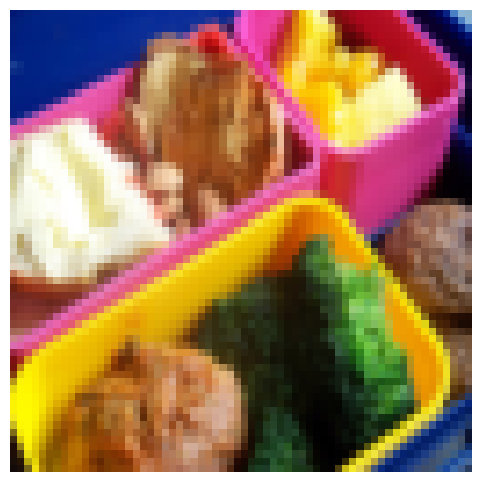

In [18]:
plot_rgb(image)

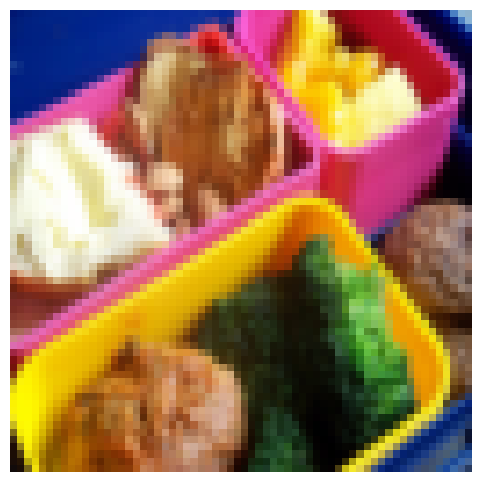

In [19]:
reconstruct_lab(l_channel, ab_channels)

## Data Preparation

We split our dataset in train and test data.

In [6]:
test_size = int(0.2 * len(dataset))
train_size = len(dataset) - test_size

In [7]:
torch.manual_seed(42)
train, test = random_split(dataset, [train_size, test_size], torch.Generator().manual_seed(42))

train_loader = DataLoader(train, batch_size=64, shuffle=True)
test_loader = DataLoader(test, batch_size=64, shuffle=True)

In [22]:
for x in train_loader:
    print(len(x)) # x is a list of len 5: image, l_channel, a_channel, b_channel, ab_channels
    print(f"Image shape {x[0].shape}\nL shape {x[1].shape}\nA shape {x[2].shape}\nB shape {x[3].shape}\nAB shape {x[4].shape}")
    break

5
Image shape torch.Size([64, 3, 64, 64])
L shape torch.Size([64, 1, 64, 64])
A shape torch.Size([64, 64, 64])
B shape torch.Size([64, 64, 64])
AB shape torch.Size([64, 2, 64, 64])


## CNN Model

For the moment, we will work with a small subset of the training data

In [8]:
torch.manual_seed(42)
train_size = 5000
small_train, _ = random_split(train, [train_size, len(train) - train_size], torch.Generator().manual_seed(42))
small_train_loader = DataLoader(small_train, batch_size=64, shuffle=True)
test_size = 1000
small_test, _ = random_split(test, [test_size, len(test) - test_size], torch.Generator().manual_seed(42))
small_test_loader = DataLoader(small_test, batch_size=64, shuffle=True)

In [18]:
len(small_train), len(small_test)

(5000, 1000)

## Training

In [20]:
model = BaselineCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [21]:
NUM_EPOCHS = 10
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    test_loss = 0.0

    # train loop
    model.train()
    progress_bar = tqdm(small_train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=True)
    for _, l_channels, _, _, ab_channels in progress_bar:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)
        
        optimizer.zero_grad()
        outputs = model(l_channels)
        loss = criterion(outputs, ab_channels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        progress_bar.set_postfix(loss=(running_loss / (progress_bar.n + 1)))
    
    train_losses.append(running_loss / len(small_train_loader))
    print(f"Epoch {epoch + 1}, Train Loss: {train_losses[-1]}")
    
    # test loop
    model.eval()
    with torch.no_grad():
        for _, l_channels, _, _, ab_channels in tqdm(small_test_loader, desc='Testing', leave=True):
            l_channels = l_channels.to(device)
            ab_channels = ab_channels.to(device)
            
            outputs = model(l_channels)
            loss = criterion(outputs, ab_channels)
            test_loss += loss.item()
        
    test_loss /= len(small_test_loader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch + 1}, Validation Loss: {test_loss}")
    
print('Finished Training')

Epoch 1/10: 100%|██████████| 79/79 [00:40<00:00,  1.96it/s, loss=0.00602]


Epoch 1, Train Loss: 0.006024365372295621


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]


Epoch 1, Validation Loss: 0.0031073409627424553


Epoch 2/10: 100%|██████████| 79/79 [00:40<00:00,  1.93it/s, loss=0.00306]


Epoch 2, Train Loss: 0.0030566947682041535


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]


Epoch 2, Validation Loss: 0.0031491905683651567


Epoch 3/10: 100%|██████████| 79/79 [00:39<00:00,  2.00it/s, loss=0.00305]


Epoch 3, Train Loss: 0.0030540091345157426


Testing: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]


Epoch 3, Validation Loss: 0.0031424300104845315


Epoch 4/10: 100%|██████████| 79/79 [00:38<00:00,  2.07it/s, loss=0.00309]


Epoch 4, Train Loss: 0.003086337306878612


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.44it/s]


Epoch 4, Validation Loss: 0.003087241420871578


Epoch 5/10: 100%|██████████| 79/79 [00:40<00:00,  1.97it/s, loss=0.00305]


Epoch 5, Train Loss: 0.0030545965397046713


Testing: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]


Epoch 5, Validation Loss: 0.0030717412009835243


Epoch 6/10: 100%|██████████| 79/79 [00:39<00:00,  1.98it/s, loss=0.00304]


Epoch 6, Train Loss: 0.003042117315285568


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Epoch 6, Validation Loss: 0.0030930733046261594


Epoch 7/10: 100%|██████████| 79/79 [00:46<00:00,  1.71it/s, loss=0.00305]


Epoch 7, Train Loss: 0.0030457449434442988


Testing: 100%|██████████| 16/16 [00:14<00:00,  1.13it/s]


Epoch 7, Validation Loss: 0.003104749077465385


Epoch 8/10: 100%|██████████| 79/79 [02:37<00:00,  1.99s/it, loss=0.00307]


Epoch 8, Train Loss: 0.0030653488297675605


Testing: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


Epoch 8, Validation Loss: 0.0030905507010174915


Epoch 9/10: 100%|██████████| 79/79 [02:47<00:00,  2.12s/it, loss=0.00303]


Epoch 9, Train Loss: 0.003032591983770268


Testing: 100%|██████████| 16/16 [00:18<00:00,  1.13s/it]


Epoch 9, Validation Loss: 0.003079509813687764


Epoch 10/10: 100%|██████████| 79/79 [02:56<00:00,  2.23s/it, loss=0.00305]


Epoch 10, Train Loss: 0.003051017546625454


Testing: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]

Epoch 10, Validation Loss: 0.0031210009765345603
Finished Training


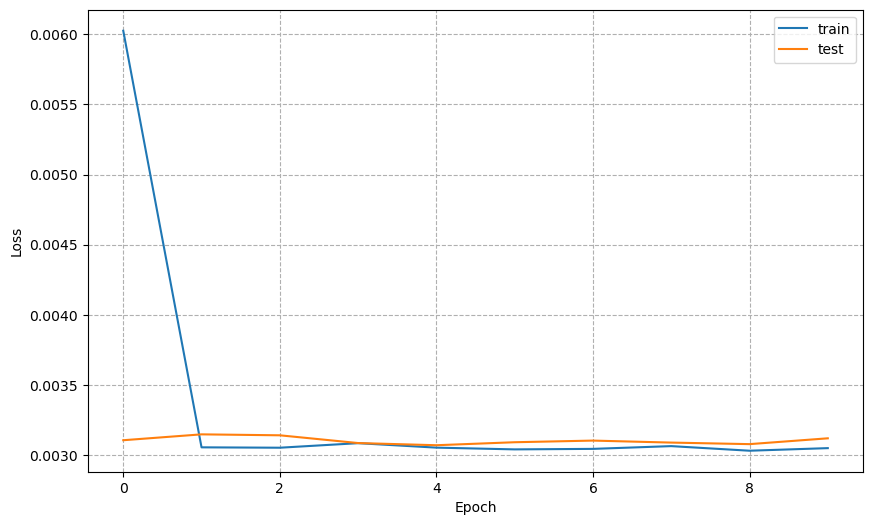

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(linestyle = "--")
plt.legend()
plt.show()

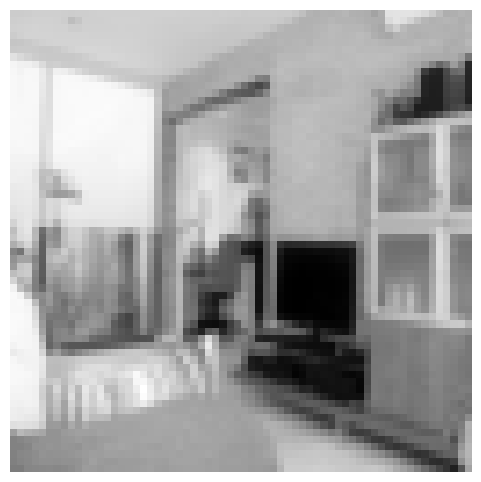

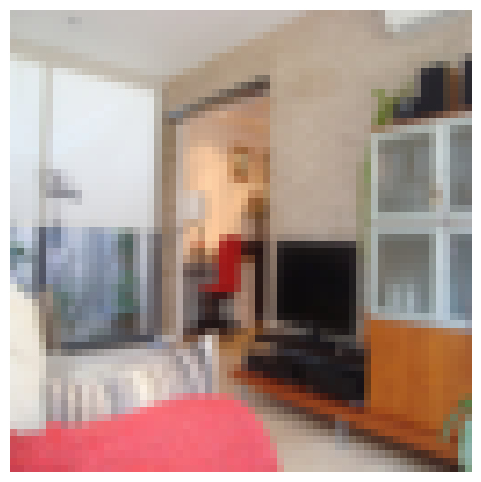

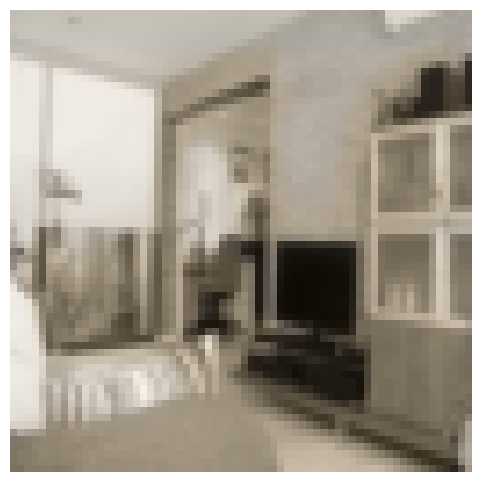

In [23]:
plot_predicted_image(model, dataset[76543])

# Save and Load Model

In [24]:
save_model(model, "baseline")

Model saved to models\baseline.pth successfully!


In [9]:
loaded_model = load_model(BaselineCNN(), "models/baseline.pth").to(device)

BaselineCNN model loaded successfully!


In [10]:
next(loaded_model.parameters()).device # check model is on the right device

device(type='cuda', index=0)

# Eval

0.0011477029183879495


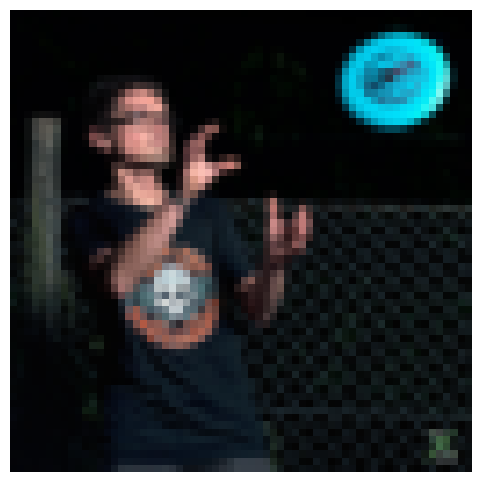

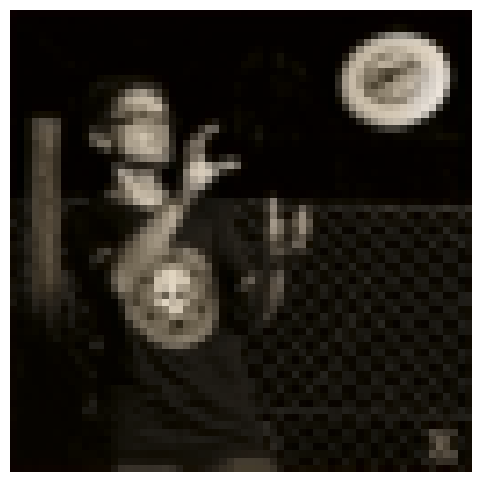

In [68]:
img = dataset[5476]
print(F.mse_loss(img[-1].to(device), loaded_model(img[1].to(device))).item())
plot_rgb(img[0])
reconstruct_lab(img[1].detach().cpu(), loaded_model(img[1].to(device)).detach().cpu())

In [57]:
loaded_model.eval()

total_mse = 0
total_psnr = 0
num_samples = 0

with torch.no_grad():
    for _, l_channels, _, _, ab_channels in small_test_loader:
        l_channels = l_channels.to(device)
        ab_channels = ab_channels.to(device)

        ab_preds = loaded_model(l_channels)

        mse = F.mse_loss(ab_preds, ab_channels)
        total_mse += mse.item() * ab_channels.size(0)

        max_pixel_value = 1.0  # image values are between 0 and 1
        psnr = 20 * torch.log10(max_pixel_value**2 / mse)
        total_psnr += psnr.item() * ab_channels.size(0)

        num_samples += ab_channels.size(0)

avg_mse = total_mse / num_samples
avg_psnr = total_psnr / num_samples

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average PSNR: {avg_psnr:.4f}")

Average MSE: 0.0031
Average PSNR: 25.0701
